In [2]:
#@title File navigation
%%capture
%pip install logomaker
%cd /content/drive/My Drive/Classes/Fall 2021/Machine Learning in Genomics/Colab Notebooks/

In [3]:
#@title Imports
import torch, time, pickle, logomaker, random
import numpy as np
import pandas as pd
import io, requests
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#@title Allow access to files in my drive
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/Classes/Fall 2021/Machine Learning in Genomics/Colab Notebooks/


Mounted at /content/drive
/content/drive/My Drive/Classes/Fall 2021/Machine Learning in Genomics/Colab Notebooks


In [5]:
#@title Read In Data
def read_data(base_assignments = {"A":0,"C":1,"G":2,"T":3}, use_data="regular"):
  #ethans
  if use_data == "regular":
    with open("./sequence.padded.txt") as seq_file:
    #with open("/content/drive/MyDrive/sequence.padded.txt") as seq_file:
      data = seq_file.read().splitlines()
    k_dict = base_assignments
    i_size = len(data)
    j_size = len(data[1])
    k_size = 4 #options of bases (ATCG) - might want to use 5 if including U
    input_matrix = np.zeros((i_size,j_size,k_size))
    i=0
    for seq in data:
        j=0
        for base in seq:
            k = k_dict[base]
            input_matrix[i,j,k] = 1
            j += 1
        i += 1
  else:
    data = "ATTTAATATAAAATTTGGCCGCCATAAAAAAA" 
    k_dict = base_assignments
    i_size = 1
    j_size = len(data)
    k_size = 4 #options of bases (ATCG) - might want to use 5 if including U
    input_matrix = np.zeros((i_size,j_size,k_size))
    j=0
    for base in data:
        k = k_dict[base]
        input_matrix[0,j,k] = 1
        j += 1
  #data = input_text.splitlines()
  
  print("Input Matrix Shape: %s" % str(input_matrix.shape))
  CC_sequences_padded = pd.read_csv(io.StringIO(requests.get('https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt').text), sep=",", header=None).to_numpy()
  #not used for this version of the EM algorithm
  #data_ss = [np.sum(input_matrix[:,:,b]) for b in range(4)]
  return(input_matrix, CC_sequences_padded)

In [6]:
#@title Initialize Parameters

def init_EM(N,L,P,K):
  #Initializing Lmbda
  lmda=torch.rand(L-P+1)
  lmda=lmda/torch.sum(lmda,axis=0).item()
  #print('lmda:',lmda)
  #print('lmda sum:',torch.sum(lmda,axis=0))
  #Initializing C matrix where C[i,j]= P(Ci=j | Xi,theta)
  C=torch.zeros(N,L-P+1)
  for i in range(N):
    C[i]=lmda
  #print('C.shape:',C.shape) 
  #print('1-C sum:',torch.sum(1-C,axis=1)) 
  #Initializing psi_0 and psi_1

  psi_0=torch.rand(P,K)
  psi_0_sum=torch.sum(psi_0,axis=1)
  psi_0_sum=torch.reshape(psi_0_sum,(P,1))
  #print(psi_0_sum.shape)
  psi_0=psi_0/psi_0_sum
  #print('psi_0 sum along k:',torch.sum(psi_0,axis=1))


  psi_1=torch.rand(P,K)
  psi_1_sum=torch.sum(psi_1,axis=1)
  psi_1_sum=torch.reshape(psi_1_sum,(P,1))
  psi_1=psi_1/psi_1_sum
  #print('psi_1 sum along k:',torch.sum(psi_1,axis=1))

  theta = {"psi_1":psi_1, "psi_0":psi_0, "C":C, "lmda":lmda}

  return theta


In [7]:
#@title E Step
def calc_Expectation(C,lmda,psi_0,psi_1,X,N,L,P,K):
  # C=torch.zeros_like(C).to(device)
  for i in range(N):
    for j in range(L-P+1):
      C[i,j]=torch.log10(lmda[j])
      for p in range(P):
        for k in range(K):
          C[i,j]=C[i,j]+X[i,j,p,k]*(torch.log10(psi_1[p,k])-torch.log10(psi_0[p,k]))
          
  # print(C)
  # print(C.shape)
  # # #Inversing the logarithm.
  C=torch.pow(C,10)
  # print(C)
  #Dividing by the denominator 
  C_sum=torch.sum(C,axis=1)
  C_sum=torch.reshape(C_sum,(C_sum.shape[0],1))
  #print(C_sum.shape)
  C=C/C_sum
  
  #print('Calc_Expect fn step; C sum:', torch.sum(C,axis=1))
  return C



In [8]:
#@title Alternate E Steps
def E_step3(Xijpk, theta, TFBS_l=18):
  psi1, psi0, lmbda = theta['psi_1'], theta['psi_0'], theta['lmda']
  C = np.zeros([Xijpk.shape[0], Xijpk.shape[1]])
  for i in range(Xijpk.shape[0]):
    for j in range(Xijpk.shape[1]):
      numerator_term1 = 1
      numerator_term2 = 1
      for p in range(TFBS_l):
        am = np.argmax(Xijpk[i,j,p,:])
        #numerator_term1 = numerator_term1 * psi1[p,am]
        numerator_term1 = logsumexp([numerator_term1, psi1[p,am]])
      for j2 in range(Xijpk.shape[1]):
        if j2 != j:
          for p in range(TFBS_l):
            am = np.argmax(Xijpk[i,j,p,:])
            #numerator_term2 = numerator_term2 * psi0[p,am]
            numerator_term2 = logsumexp([numerator_term2, psi0[p,am]])
      #C[i,j] = lmbda[j] *  numerator_term1 * numerator_term2
      C[i,j] = logsumexp([lmbda[j], numerator_term1, numerator_term2])  
      den_term1 = 1
      den_term2 = 1
      den_term3 = 1
      den_total = 0
      for jp in range(Xijpk.shape[1]):
        for p in range(TFBS_l):
          am = np.argmax(Xijpk[i,jp,p,:])
          den_term1 = logsumexp([psi1[p,am], den_term1])
        for jpp in range(Xijpk.shape[1]):
          if jpp != jp:
            am = np.argmax(Xijpk[i,jpp,p,:])
            den_term2 = logsumexp([psi0[p,am], den_term2])
        den_term3 = logsumexp([lmbda[jp], den_term1, den_term2])
        den_total = den_total + den_term3
      C[i,j] = logsumexp([C[i,j], (1/den_total)])
  for i in range(Xijpk.shape[0]):
    for j in range(Xijpk.shape[1]):
      C[i,j] = C[i,j] / C.sum(axis=1)[i]
  return torch.tensor(C)

def new_calc_E(theta,X,N,L,P,K):
  C,lmda,psi_0,psi_1 = theta['C'], theta['lmda'], theta['psi_0'], theta['psi_1']
  C=torch.zeros_like(C)
  repeat_term=torch.zeros(N)
  
  #Calculating the common term,,, the term encircled in the notes
  for i in range(N):
    for j in range(L-P+1):
      for p in range(P):
        for k in range(K):
          repeat_term[i]+=X[i,j,p,k]*torch.log10(psi_0[p,k])

  # #repeat_term=torch.sum(repeat_term,axis=1)
  repeat_term=torch.reshape(repeat_term,(N,1))
  C=C+repeat_term
  #calculating the rest
  for i in range(N):
    for j in range(L-P+1):
      C[i,j]+=torch.log10(lmda[j])
      for p in range(P):
        for k in range(K):
          C[i,j]+=X[i,j,p,k]*(torch.log10(psi_1[p,k])-torch.log10(psi_0[p,k]))
  C_min=torch.min(C,axis=1,keepdims=True)[0]
  C=C-C_min
  # Inversing the logarithm
  C=torch.pow(C,10)
  # Dividing the whole rows by the sum of the rows,,, the denominator term
  C_sum=torch.sum(C,axis=1,keepdims=True)
  #C_sum=torch.reshape(C_sum,(C_sum.shape[0],1))
  C=C/C_sum
  
  return C   


In [9]:
#@title Alternate M Step
def calc_Mstepasdfsa(theta,X,N,L,P,K):  
  C,lmda,psi_0,psi_1 = theta['C'], theta['lmda'], theta['psi_0'], theta['psi_1']
  lmda=torch.sum(C,axis=0)/N
  # print(lmda.shape)
  # print(lmda)
  
  #The M Step for psi_1
  #reshape C for help in broadcasting later
 
  C_rshp=torch.reshape(C,(C.shape[0],C.shape[1],1,1))
  S=X*C_rshp
  S=torch.sum(S,axis=(0,1))
  psi_1=S/N

  # C_=torch.zeros(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
  # for i in range(X.shape[0]):
  #   for j in range(X.shape[1]):
  #     C_[i,j,:,:]=C[i,j]
  # S=X*C_    
  # print('S.shape:', S.shape)
  
  # #print(psi_1)
  # #print(torch.sum(psi_1,axis=1))
  # #The M Step for psi_0

  C_reshp_0=-1*C + 1
  C_reshp_0=torch.reshape(C_reshp_0,(C_reshp_0.shape[0],C_reshp_0.shape[1],1,1))
  S_0=X*C_reshp_0
  S_0=torch.sum(S_0,axis=(0,1))
  psi_0=S_0/((L-P)*N)
  
  # #oo=C_reshp_0-C
  # #print(oo.shape)
  # #print(C)
  
  # C_1=torch.zeros(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
  # for i in range(X.shape[0]):
  #   for j in range(X.shape[1]):
  #     C_1[i,j,:,:]=C_reshp_0[i,j]
  # S_0=X*C_1
  # print('S_0.shape:',S_0.shape)
  # S_0=torch.sum(S_0,axis=(0,1))
  
   ###### Using For loops########### ### for your understanding ETHAN   #####

  # psi_1=torch.zeros_like(psi_1)
  # psi_0=torch.zeros_like(psi_0)

  # for p in range(P):
  #   for k in range(K):
  #     for i in range(N):
  #       for j in range(L-P+1):
  #         psi_1[p,k]+=X[i,j,p,k]*C[i,j]
  #         psi_0[p,k]+=X[i,j,p,k]*(1-C[i,j])

  # psi_1=psi_1/N
  # psi_0=psi_0/(N*(L-P))  

  #print(psi_0)
  return lmda,psi_0,psi_1

In [10]:
#@title M Step
def calc_Mstep(theta,X,N,L,P,K):  
  C,lmda,psi_0,psi_1 = theta['C'], theta['lmda'], theta['psi_0'], theta['psi_1']
  lmda=torch.sum(C,axis=0)/N
  lmda+=0.000001
  lmda/=torch.sum(lmda)
  # print(lmda.shape)
  # print(lmda)
  
  #The M Step for psi_1
  #reshape C for help in broadcasting later
 
  C_rshp=torch.reshape(C,(C.shape[0],C.shape[1],1,1))
  S=X*C_rshp
  S=torch.sum(S,axis=(0,1))
  psi_1=S/N
  psi_1=psi_1+0.000001
  psi_1=psi_1/torch.sum(psi_1,axis=1,keepdims=True)
  # C_=torch.zeros(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
  # for i in range(X.shape[0]):
  #   for j in range(X.shape[1]):
  #     C_[i,j,:,:]=C[i,j]
  # S=X*C_    
  # print('S.shape:', S.shape)
  
  # #print(psi_1)
  # #print(torch.sum(psi_1,axis=1))
  # #The M Step for psi_0

  C_reshp_0=-1*C + 1
  C_reshp_0=torch.reshape(C_reshp_0,(C_reshp_0.shape[0],C_reshp_0.shape[1],1,1))
  S_0=X*C_reshp_0
  S_0=torch.sum(S_0,axis=(0,1))
  psi_0=S_0/((L-P)*N)
  psi_0=psi_0+0.000001
  psi_0=psi_0/torch.sum(psi_0,axis=1,keepdims=True)
  
  # #oo=C_reshp_0-C
  # #print(oo.shape)
  # #print(C)
  
  # C_1=torch.zeros(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
  # for i in range(X.shape[0]):
  #   for j in range(X.shape[1]):
  #     C_1[i,j,:,:]=C_reshp_0[i,j]
  # S_0=X*C_1
  # print('S_0.shape:',S_0.shape)
  # S_0=torch.sum(S_0,axis=(0,1))
  
   ###### Using For loops########### ### for your understanding ETHAN   #####

  # psi_1=torch.zeros_like(psi_1)
  # psi_0=torch.zeros_like(psi_0)

  # for p in range(P):
  #   for k in range(K):
  #     for i in range(N):
  #       for j in range(L-P+1):
  #         psi_1[p,k]+=X[i,j,p,k]*C[i,j]
  #         psi_0[p,k]+=X[i,j,p,k]*(1-C[i,j])

  # psi_1=psi_1/N
  # psi_0=psi_0/(N*(L-P))  

  #print(psi_0)
  return lmda,psi_0,psi_1

Logliklihood

In [11]:
def my_logsumexp(x):
    try:
      c = np.max(x)
      lse = c + np.log(np.sum(np.exp(x - c)))
      lse_final = np.exp(x - logsumexp(x))
    except:
      c = torch.max(x)
      lse = c + torch.log(torch.sum(torch.exp(x - c)))
      lse_final = torch.exp(x - logsumexp(x))
    return lse_final

#@title Calc LogLikelihood
def calc_logliklihood(theta,X,N,L,P,K):
  C, psi_1, psi_0, lmda = theta['C'], theta['psi_1'], theta['psi_0'], theta['lmda']
  liklihood=0
  for i in range(N):
    for j in range(L-P+1):
      liklihood+=C[i,j]*torch.log(lmda[j])
  for i in range(N):
    for j in range(L-P+1): 
      for p in range(P):
        for k in range(K):
          #in the following line are you concerned about underflow when multiplying C[i,j] by torch.log(psi_1[p,k]
          #print(X[i,j,p,k]*(C[i,j]*torch.log(psi_1[p,k]) + (1-C[i,j])*torch.log(psi_0[p,k])))
          liklihood+= X[i,j,p,k]*(C[i,j]*torch.log(psi_1[p,k]) + (1-C[i,j])*torch.log(psi_0[p,k])) 
  return liklihood   

def calc_LLH(Xijpk, theta):
  psi_0, psi_1, lmbda, posteriors = theta['psi_0'], theta['psi_1'], theta['lmda'], theta['C']
  term1 =  (posteriors * np.log(lmbda)).sum(axis=(0,1))
  complement_posteriors = 1 - posteriors
  term2_1 = 0
  for seq in range(0,Xijpk.shape[0]):
   for base in range(0, posteriors.shape[1]):
     for p in range(0, psi_1.shape[0]):
       for k in range(0, psi_1.shape[1]):
         term2_1 = term2_1 + (posteriors[seq, base] * np.log(psi_1[p,k]))
  term2_2 = 0
  for seq in range(0, Xijpk.shape[0]):
   for base in range(0, posteriors.shape[1]):
     for p in range(0, psi_0.shape[0]):
       for k in range(0, psi_0.shape[1]):
         temp = Xijpk[seq, base, p, k] * (complement_posteriors[seq, base] * np.log(psi_0[p,k]))
         term2_2 = term2_2 + temp
  term2 = term2_1 + term2_2
  LLH = term1 + term2
  return LLH


In [12]:
#@title Calc ELBO
def calc_ELBO(LLH, C):
  #print(C)
  entropy=torch.zeros_like(C)
  C[torch.where(C==0)]= 1
  entropy = C * torch.log(C)
  entropy = torch.sum(entropy, axis=(0,1))
  ELBO = LLH - entropy
  return ELBO

In [13]:
#@title Visualization Functions
def compare_psi(all_thetas):
  #criterion = torch.nn.CrossEntropyLoss()
  loss_matrix = pd.DataFrame(index=range(len(all_thetas)), columns=range(len(all_thetas)))
  for rand_init in range(len(all_thetas)):
    sns.heatmap(all_thetas[rand_init][-1]['psi_1'].numpy())
    for rand_init_2 in range(len(all_thetas)):
      psi_loss = np.linalg.norm(all_thetas[rand_init][-1]['psi_1'].numpy() - all_thetas[rand_init_2][-1]['psi_1'].numpy())
      #print(psi_loss)
      #print("%d, %d" %(rand_init, rand_init_2))
      loss_matrix.iloc[rand_init, rand_init_2] = psi_loss
      #print(loss_matrix)
  return(loss_matrix)

def make_logo(psi, title):
 
  TFBS_logo_df = pd.DataFrame(psi.numpy())
  TFBS_logo_df.columns = ["A","C","G","T"]


  TFBS_logo = logomaker.Logo(TFBS_logo_df, width=.8, vpad=.05,
                          fade_probabilities=False,
                          stack_order='big_on_top',
                          color_scheme='classic',
                          font_name='DejaVu Sans')

  # style using Logo methods
  #TFBS_logo.style_spines(spines=['left', 'right'], visible=False)

  # style using Axes methods
  TFBS_logo.ax.set_xticks(range(len(TFBS_logo_df)))
  TFBS_logo.ax.set_xticklabels(range(len(TFBS_logo_df)))
  TFBS_logo.ax.set_yticks([0, 0.25, .5, 0.75, 1])
  TFBS_logo.ax.set_ylabel('probability')
  TFBS_logo.ax.set_title(title)


In [14]:
#@title Run EM
def run_EM(random_inits=5, epochs=20, alt_data=np.zeros([0,0,0]), use_data='regular'):
  tracker = {"all_ELBOs":[], 'all_thetas':[]}
  if alt_data.shape[0] == 0:
    x, truth = read_data(use_data=use_data)
  else:
    x = alt_data
  x=torch.from_numpy(x)
  N=x.shape[0]
  L=x.shape[1]
  K=x.shape[2]
  P=18
  # x[i,j:j+P,:]
  X=torch.zeros(N,L-P+1,P,K)
  for i in range (N):
    for j in range(L-P+1):
      X[i,j]=x[i,j:j+P,:]
    t1 = time.time()
  for random_init in range(random_inits):
    t2 = time.time()
    theta = init_EM(N,L,P,K)
    LLH = calc_logliklihood(theta, X,N,L,P,K)
    ELBO = calc_ELBO(LLH, theta['C'])
    print("Random Init: %d Initial ELBO: %.5f" %(random_init, ELBO))
    tracker['all_ELBOs'].append([ELBO])
    tracker['all_thetas'].append([theta])
    for epoch in range(epochs):
      t3 = time.time()
      theta['C'] = new_calc_E(theta,X,N,L,P,K)
      #theta['C'] = E_step3(X, theta)
      theta['lmda'], theta['psi_0'], theta['psi_1'] = calc_Mstep(theta, X,N,L,P,K)
      LLH = calc_logliklihood(theta,X,N,L,P,K)
      ELBO = calc_ELBO(LLH, theta['C'])
      print("Epoch: [%d,%d] ELBO: %s" %(random_init, epoch, str(ELBO)))
      tracker['all_ELBOs'][random_init].append(ELBO)
      tracker['all_thetas'][random_init].append(theta)
      #print("Time for Epoch: %d" %(time.time() - t3))
    #print("Time for Random Init: %d" %(time.time()-t2))
  return tracker

Question 1

The model was run for 5 random initializations for 20 epochs in each itertion with full data batches.

In [ ]:
#@title Question 1. 
#Plot the log likelihood as a function of EM iteration, for 5 iterations, for 20 different random initializations of
#he model parameter. Does the log likelihood monotonically increase every iteration of every initialization?
#@ Question 1
q1_log = run_EM()
q1_safe = q1_log.copy()
with open('q1_log', 'wb') as f:
  pickle.dump(q1_log, f)  
with open('q1_log', 'rb') as f:
  q1_log = pickle.load(f)

#plot ELBO
all_ELBOs = q1_log['all_ELBOs']
for i in range(len(all_ELBOs)):
  last_ELBO = float("-inf")
  plt.plot(all_ELBOs[i])
  # for e in range(len(all_ELBOs[i])):
  #   if all_ELBOs[i][e] < last_ELBO:
  #     print("ALERT: Decreasing ELBO at Run %d, Position %d" %(i, e))
  #   last_ELBO = all_ELBOs[i][e]


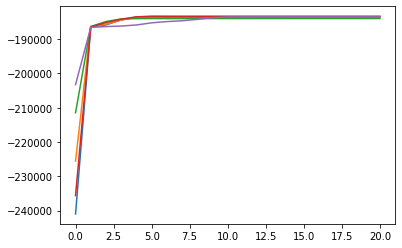

In [ ]:
#@title plot ELBO
all_ELBOs = q1_log['all_ELBOs']
for i in range(len(all_ELBOs)):
  last_ELBO = float("-inf")
  plt.plot(all_ELBOs[i])
  plt.xlabel("Epoch")
  plt.ylabel("ELBO")
  plt.title("ELBO by Epoch of last Random Init")

Lambda generally seems to find a TFBS start site within a few positions of the actual TFBS ss. While this is not ideal, this suggests that the algorithm is recognizing the motif; however, it does not always determine the proper bounds of the motif. See the response to question 3 for expansion on this point. Additionally, lambda displaysa high probability for one base and very low for the rest. This shows that lambda is making a decisive choice and not spreading out its predictions between multiple positions. 

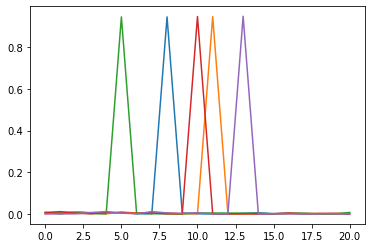

In [ ]:
#@title Plot Lambda
all_thetas = q1_log['all_thetas']
for i in range(len(all_thetas)):
  plt.plot(all_thetas[i][-1]['lmda'])
  plt.xlabel("Position")
  plt.ylabel("Foreground Probability")

Question 2

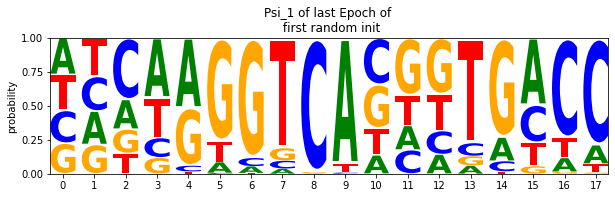

In [ ]:
#@title Question 2. 
#draw a sequence logo visualization of the foreground motif your model learns, ψ(l)k,p.

#visualize psi_1 of the last epoch of the first random init
theta = q1_log['all_thetas'][0][-1]
psi_1 = theta['psi_1']
make_logo(psi_1, "Psi_1 of last Epoch of \n first random init")

Question 3. Compare psi_1 across different random initializations. 
To accomplish this a heatmap was generated. The heatmap shows the euclidean distance between each pair of psi variables. However, this does not reveal much about how the psi variables differ. For a closer look at different psi variables, a few sequence logos are generated. After further inspection of the psi_1 logos for different random inits it appears they have a commonalilty in a few salient bases. The majority of positions in all psi_1 variables appear to show roughly equal probabilities of each base; however, of note is that all psi_1 variables appear to contain a GGTCA stretch at variable locations within psi. These GGTCA stretches are characterized by high (at least 60%) probability of these bases. This may reveal that the EM algorithm is identifying these as conserved bases across each TFBS, but it has trouble identifying where within the TFBS these are located. This may be due to lack of capacity in the algorithm or it may just be a biological reality that the majority of the TFBS is random noise around this salient group of bases. 
Additionally, it appears that there might be a TGAC* esque sequence that follows the GGTCA separated by seemingly 3 bases. This is not present in all random iterations possibly due to finding a local minumim that doesnt account for these bases. This TGAC motif is present toward the end of the psi_1 of the first and second random initializations and appears to start but get cut off in psi_1 of the third random initialization. The differences in our motifs are likely due to each random initialization finding one of the many local minimum.

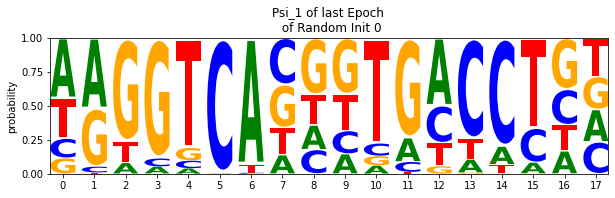

In [ ]:
#@title Psi_1 logo for last epoch of second random init
theta = q1_log['all_thetas'][1][-1]
psi_1 = theta['psi_1']
make_logo(psi_1, "Psi_1 of last Epoch \n of Random Init 0")

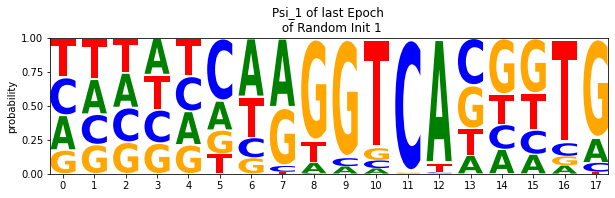

In [ ]:
#@title Psi_1 logo for last epoch of third random init
theta = q1_log['all_thetas'][2][-1]
psi_1 = theta['psi_1']
make_logo(psi_1, "Psi_1 of last Epoch \n of Random Init 1")

Text(0.5, 1.0, 'Euclidean Distance \n between the Psi_1 of last Epoch \n of each Random Initialization')

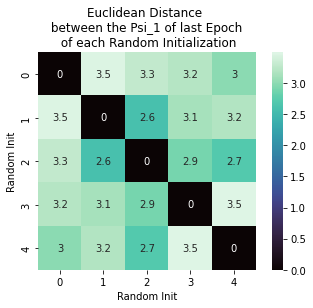

In [ ]:
#@title Question 3.
#Now run your model using model random initializations. How do the model parameters ψ(l)k,p compare across runs?
#What about their log likelihoods?

#compare psi from across all random inits
loss_matrix = compare_psi(q1_log['all_thetas'])
loss_matrix.fillna(0, inplace=True)
#print(loss_matrix)
plt.clf()
a = sns.heatmap(loss_matrix, square=True, annot=True, cmap="mako")
a.set_xlabel("Random Init")
a.set_ylabel("Random Init")
a.set_title("Euclidean Distance \n between the Psi_1 of last Epoch \n of each Random Initialization")


The LLH for each Psi seems to be relatively constant by the last epoch for each random initialization.

[tensor(-183557.2344), tensor(-183367.0469), tensor(-183964.3281), tensor(-183316.9688), tensor(-183473.6406)]


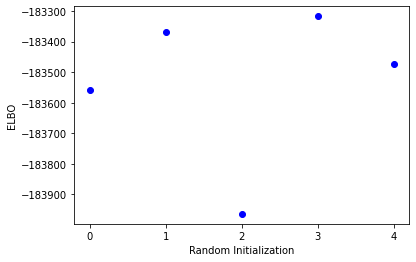

In [ ]:
#@title Question 3 Continued Psi LLH comparrisons
#how do you calculate LLH for just psi??
all_last_ELBOs = q1_log['all_ELBOs'][:]
all_last_ELBOs = [all_last_ELBOs[i][-1] for i in range(len(all_last_ELBOs))]
print(all_last_ELBOs)
fig = plt.figure()
pl = plt.scatter(range(len(all_last_ELBOs)), all_last_ELBOs, color='blue')
plt.xticks(range(len(all_last_ELBOs)))
plt.xlabel("Random Initialization")
plt.ylabel("ELBO")
plt.show()


Question 4
By visualiziing C from the last Epoch of differenet random initializations, we see that for each N the posteriors are largely consistent. Additionally, we see that there is generally one or two positions with high probaility. This is indicative of the model identifying a TFBS start site with high confidence (but also sometimes a second best choice). This may be due to the insight from earlier inspection of psi_1 which revealed possibly two salient motifs within the TFBS. The model may be queing in on both of these and thus distributing the posteriors bimodally as seen in some of the heatmap visualizations below.

Input Matrix Shape: (357, 38, 4)


Text(0.5, 1.0, 'C matrix for last Epoch of First Random Init \nwith True Start Site at Position 10')

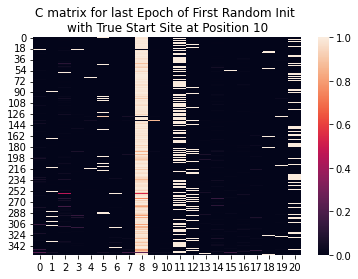

In [ ]:
#@title Question 4
#Plot a figure that shows the distribution over Ci,j for a few of the input sequences, and compare that (in the
#visualization) to the ground truth. How close was your model to predicting the real motif location?
a,truth = read_data() 
#visualize C
C_first = q1_log['all_thetas'][0][-1]['C'].numpy()
C_second = q1_log['all_thetas'][1][-1]['C'].numpy()
C_third = q1_log['all_thetas'][2][-1]['C'].numpy()

plt.clf()
sns.heatmap(C_first).set_title("C matrix for last Epoch of First Random Init \nwith True Start Site at Position " + str(np.argmax(truth[0])))

Text(0.5, 1.0, 'C matrix for last Epoch of Second Random Init \nwith True Start Site at Position 10')

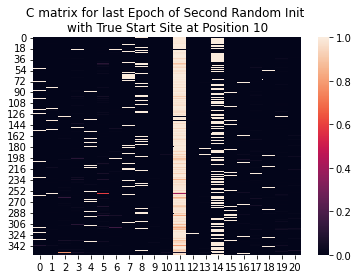

In [ ]:
sns.heatmap(C_second).set_title("C matrix for last Epoch of Second Random Init \nwith True Start Site at Position " + str(np.argmax(truth[1])))


Text(0.5, 1.0, 'C matrix for last Epoch of Third Random Init \nwith True Start Site at Position10')

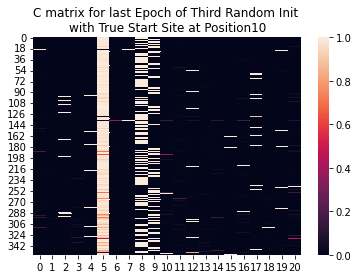

In [ ]:
sns.heatmap(C_third).set_title("C matrix for last Epoch of Third Random Init \nwith True Start Site at Position" + str(np.argmax(truth[2])))


Question 5 Response



ELBO from our model: -39234.7148
ELBO from simple model: -1.3869

While the ELBO is vastly different for our model than for the simple model this is not unexpected. Our model essentially has more data since each position within the sequence now represents an 18bp motif. This increases the number of negative terms summed in the LLH calculation and thus decreases ELBO (increases the magnitude). 

In [ ]:
#@title Question 5.
#Train your model using 80% of the data, holding out the remaining 20%. Evaluate the log likelihood of your held
#out data using the model you implemented in this assignment, and compare it to the log likelihood from the simple
#latent model we used in class, using the same training/held out data. Which one is better?
data, truth = read_data()
data_train = data[0:int(0.8*data.shape[0]), :, :]
data_test = data[int(0.8*data.shape[0])+1:, :, :]

q5_log = run_EM(random_inits=1, alt_data=data_train)
q5_safe = q5_log.copy()
with open('q5_log', 'wb') as f:
  pickle.dump(q5_log, f)                     
with open('q5_log', 'rb') as f:
  q5_log = pickle.load(f)

theta = q5_log['all_thetas'][-1][-1]
C_row = theta['C'].mean(axis=0)
C = pd.DataFrame([C_row for i in range(data_test.shape[0])])
data_test = torch.from_numpy(data_test)
N=data_test.shape[0]
L=data_test.shape[1]
K=data_test.shape[2]
P=18

X=torch.zeros(N,L-P+1,P,K)
for i in range(N):
  for j in range(L-P+1):
    X[i,j]=data_test[i,j:j+P,:]
LLH = calc_logliklihood(theta, X, X.shape[0],L,P,K)
ELBO = calc_ELBO(LLH, theta['C'])
print("ELBO from our model: %.4f" %(ELBO))
print("ELBO from simple model: -1.3869")

In [ ]:
#@title Question 6. Train your model on the atgcsequences.txt file (that had a GC-rich region embedded between two flanking AT-rich
#regions). Does the model work better?
q6_log = run_EM(use_data="atcg")
q6_safe = q6_log.copy()
with open('q6_log', 'wb') as f:
  pickle.dump(q6_log, f)                     
with open('q6_log', 'rb') as f:
  q6_log = pickle.load(f)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  


ELBO: -316.693


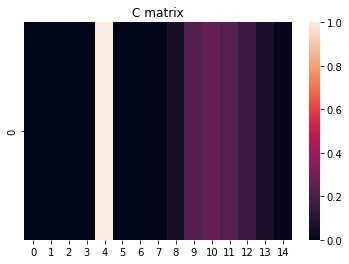

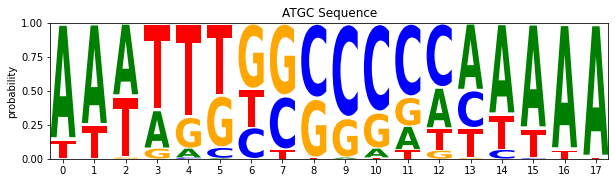

In [37]:
#@title Q6 Visualizations
q6_log = q6_safe
C_vis = q6_log['all_thetas'][1][-1]['C'].numpy()
sns.heatmap(C_vis).set_title("C matrix")
psi_1 = q6_log['all_thetas'][1][-1]['psi_1']
psi_1[np.isnan(psi_1)] = 0

print("ELBO: %.3f" %(q6_log['all_ELBOs'][1][-1]))
make_logo(psi_1, "ATGC Sequence")


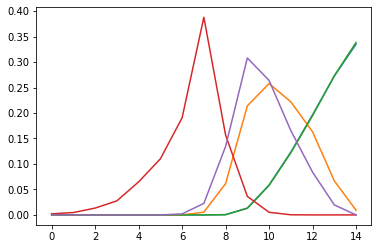

In [38]:
#@title Plot Lambda for Q6
all_thetas = q6_safe['all_thetas']
for i in range(len(all_thetas)):
  plt.plot(all_thetas[i][-1]['lmda'])

Question 6 response:
Running the model on the ATGC sequence shows that the GC rich region is recognized as important. For every random initialization, the GC rich region appears within psi_1. Lambda generally appears distributed along the GC rich region. The lambdas here are more broad in that they do not necessarily ascribe nearly 100% probability to one base. This is in contrast to running the model on the earlier 357 sequences. This reveals that the model seems to learn based off the differences between the AT and GC regions; however, without making as definitive of a decision about the TFBS start site as before. The logliklihood after 20 epochs is -316.560. For reference, the sequence used was: "ATTTAATATAAAATTTGGCCGCCATAAAAAAA" 

In [ ]:
#@title Question 7.
# # The original training set in sequence.padded.txt has 357 sequences. Randomly sample another 357 sequences of
# #the same length (just from a simple generator, that produces each base at equal frequency) and train the model
# #with all data. Does it still recover the same motif? What if you add 3000 noisy sequences?
random_mat = np.zeros([357,38,4])
for i in range(random_mat.shape[0]):
  for j in range(random_mat.shape[1]):
    random_mat[i,j, random.randint(0,3)] = 1

q7_log = run_EM(random_inits=1, epochs=20, alt_data=random_mat)
q7_safe = q7_log.copy()
with open('q7_log', 'wb') as f:
  pickle.dump(q7_log, f)                     
with open('q7_log', 'rb') as f:
  q7_log = pickle.load(f)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  after removing the cwd from sys.path.


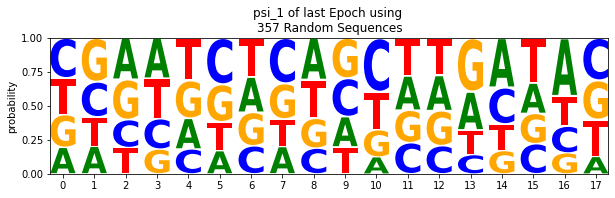

In [ ]:
#@title Q7 visualization of psi_1 of the last epoch of the last random init
theta = q7_safe['all_thetas'][-1][-1]
psi_1 = theta['psi_1']
psi_1[np.isnan(psi_1)] = 0
make_logo(psi_1, "psi_1 of last Epoch using \n357 Random Sequences")

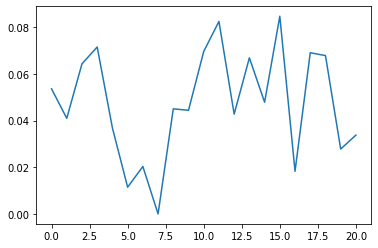

In [35]:
#@title Plot Lambda for Q7
all_thetas = q7_log['all_thetas']
for i in range(len(all_thetas)):
  plt.plot(all_thetas[i][-1]['lmda'])

As seen above, when running the model on 357 random sequences, the model generates a psi_1 distribution with seemingly random and roughly equivalent probabilities of each base at each position. This is what we would expect since there is likely no discernable pattern in the data. For a few bases, the probabilities are not exactly 25% each. This is likely due to random noise in the data since there are only 357 sequences. The lambda varaible here is very spread out amongst every base showing that the model was not able to find a decisive start point. This is logical since the data is randomly generated so any value of lambda approaches equally likely. Lambda is not completely flat likely due to noise in the data and the model finding local minimum.  

In [ ]:
#@title Question 7b 
# The original training set in sequence.padded.txt has 357 sequences. Randomly sample another 357 sequences of
#the same length (just from a simple generator, that produces each base at equal frequency) and train the model
#with all data. Does it still recover the same motif? What if you add 3000 noisy sequences?
random_mat = np.zeros([3000,38,4])
for i in range(random_mat.shape[0]):
  for j in range(random_mat.shape[1]):
    random_mat[i,j, random.randint(0,3)] = 1

q7b_log = run_EM(random_inits=1, epochs=20, alt_data=random_mat)
q7b_safe = q7b_log.copy()
with open('q7b_log', 'wb') as f:
  pickle.dump(q7b_log, f)                     
with open('q7b_log', 'rb') as f:
  q7b_log = pickle.load(f)


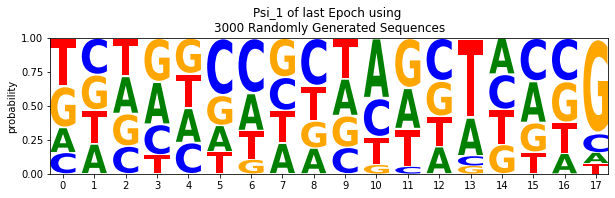

In [16]:
#@title Visualize psi_1 of the last epoch of the last random init
theta = q7b_log['all_thetas'][-1][-1]
psi_1 = theta['psi_1']
make_logo(psi_1, "Psi_1 of last Epoch using \n3000 Randomly Generated Sequences")

Running the 3000 random sequences generates results very similar to running the 357 sequences. There does seem to be a few positions here in psi that have less even distributions of probabilities for each base with 'T' and 'G' each having over 50% probability at two distinct positions. This is likely due to noise in the data leading the model to find a local optimum. The lambda varaible here is very spread out amongst every base showing that the model was not able to find a decisive start point. This is logical since the data is randomly generated so any value of lambda approaches equally likely. Lambda is not completely flat likely due to noise in the data and the model finding local minimum. The ELBO for this is greater than the ELBO for the 357 sequences due to the increase in data.

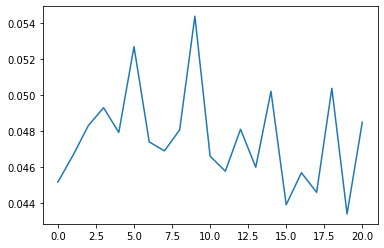

In [31]:
#@title Lambda for 3000 sequences 
all_thetas = q7b_safe['all_thetas']
for i in range(len(all_thetas)):
  plt.plot(all_thetas[i][-1]['lmda'])

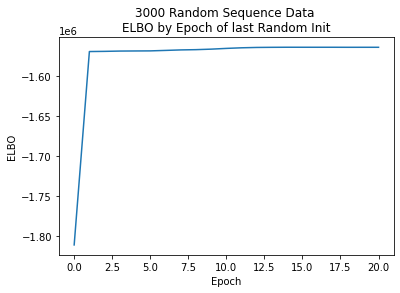

In [30]:
#@title plot ELBO
all_ELBOs = q7b_safe['all_ELBOs']
for i in range(len(all_ELBOs)):
  plt.plot(all_ELBOs[i])
  plt.xlabel("Epoch")
  plt.ylabel("ELBO")
  plt.title("3000 Random Sequence Data \nELBO by Epoch of last Random Init")